check out Neural Control Variates and Regression-based Monte Carlo Integration in bibliography and other works on sequential Monte carlo

We will focus on control variates for ODEs/recursive integral equations that are build using approximate solutions <br>

We already went through some basic examples in period1 but we haven't explained why those examples work. <br>

Ignore for the sake of simplicity the Russian Roulette:
$$
\begin{align*}
Y(t)&= 1+tY(U) \Rightarrow \\
\text{Var}(Y(t))&= t^{2} \text{Var}(Y(U))
\end{align*}
$$

Reducing $\text{Var}(Y(U))$ reduces $\text{Var}(Y(t))$ there aren't a lot first moves you can do by trial and error you can find that using the law of total variance (https://en.wikipedia.org/wiki/Law_of_total_variance) helps:

$$
\begin{align*}
\text{Var}(Y(U))&= E[\text{Var}(Y(s)) \mid U = s] + \text{Var}(E[Y(s)] \mid U =s) \\
                &= E[\text{Var}(Y(s)) \mid U = s] + \text{Var}(y(U)) 
\end{align*}
$$

Notice that both of those terms are positive because of the variances that are positive. If you  study this expression by doing control variate type transformations there stands $1$ case out. Let $q$ be a function.

$$
\begin{align*}
\text{Var}(Y(U)-q(U) + E[q(U)]) &=  \text{Var}(Y(U)-q(U)) \\
                            &=  E[\text{Var}(Y(s) -q(s)) \mid U = s] + \text{Var}(E[Y(s)-q(s)] \mid U =s) \\ 
                            &=  E[\text{Var}(Y(s)) \mid U = s] + \text{Var}(y(U)-q(U))  
\end{align*}
$$
So $q$ only influences the second term and the second term has a nice interpretation:
$$
\begin{align*}
\text{Var}(y(U)-q(U))   &= \frac{1}{t} \int_{0}^{t} (y(s)-q(s))^{2} ds - \left[ \frac{1}{t}\int_{-1}^{1} y(s)-q(s)ds \right]^{2} \\ 
                        & \le O(||y-q||^{2}_{2})   
\end{align*}
$$
This error of $y$ and $q$ is for every $t$ different a but you can bound those with the biggest $t$. <br>

A simpler analysis of variance can be done for regular Monte Carlo. We will show a derivation where don't use a clean control variate that get compensated with independent random variable $G$.

$$
\begin{align*}
\text{Var}(f(U)-g(U)+G)&=\text{Var}(f(U)-g(U)) + \text{Var}(G) \\ 
    &=\text{Var}(f(U)-g(U)) + \text{Var}(G) \\ 
    & \le  O(||f-g||_{2}^{2}) + \text{Var}(G)
\end{align*}
$$
if $G$ is obtained by Monte Carlo we then call it a MC control variate. Reducing the variance can be achieved by minimizing the error on the approximate function and reducing the variance of the Monte Carlo estimator of G. <br>

You also could use a control variate on $G$ ... if you repeat this infinite often and turn everything backwards you get multilevel Monte Carlo. So multilevel Monte Carlo is just MC control variate on MC control variate infinite times. <br>

Something similar can be done with recursive Monte Carlo a big benefit is that there is no recursion on the MC control variates. <br>

Minimizing the norm in this context could be done by stochastic gradient descent in general the approach we chose for is we think equivalent with the right set up and some work we'll side step with orthogonal theory. <br>

For simplicity we introduce orthogonal adaptive control variates for regular Monte Carlo which also van be used to do function approximation given a point estimator over a domain. <br>

Let's say we want to MC integrate $f$ over $[-1,1]$ to construct control variate we keep an approximation in an cutoff orthonormal decomposition $\sum_{n=0}^{k} a_n p_{n}(x)$ in this case of Legendre polynomials (https://en.wikipedia.org/wiki/Legendre_polynomials). To approximate the coefficients in this decomposition we again use Monte Carlo integration:

$$
\begin{align*}
a_{n}   &= \frac{2n+1}{2}\int_{-1}^{1}f(x)p_{n}(x)dx \\
        &= (2n+1)E[f(U)p_n(U)] 
\end{align*}
$$
 where that $U = \text{Uniform(-1,1)}$ and we also control variate that:

$$
\begin{align*}
a_{n}   &= (2n+1)E\left[\left(f(U)-\sum \bar{a}_j p_{j}(U) \right)p_n(U) \right] + \bar{a}_{n} 
\end{align*}
$$
Where $\bar{a}_j$ are the current estimates of the coefficients. In code this looks like this:

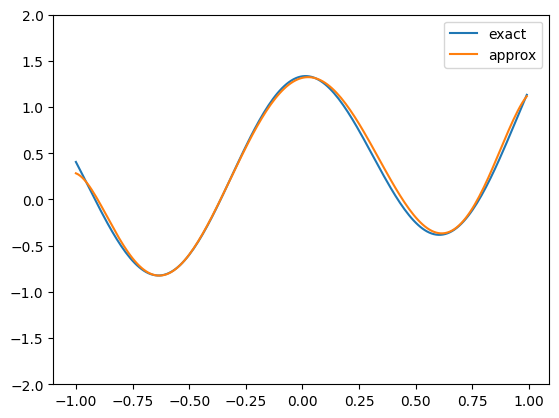

In [30]:
from random import random 
import matplotlib.pyplot as plt
import numpy as np
from math import exp, cos

# inefficient legendre polynomials RECURSION
def p(x,n):
    return ((2*n-1)*x*p(x,n-1)-(n-1)*p(x,n-2))/n if n>1 else (x if n ==1 else 1)

def f(x):
    return exp(x)/3 + cos(5*x) 

def approx_sol(a_control,x):
    return sum(a_control[j]*p(x,j) for j in range(len(a_control)))

# inefficient because we can use evaluations of f(u) and p(u,..) on all coefs at the same time
def a(n,a_control,nsim=10):
    sol = 0
    for _ in range(nsim):
        u = (random()*2-1)
        sol += ((2*n+1)*(f(u)-approx_sol(a_control,u))*p(u,n) + a_control[n])/nsim
    return sol

a_control = [0]*8
for j in range(3):
    for n in range(len(a_control)):
        a_control[n] = a(n,a_control,20)
        
xs = np.arange(-1,1,0.01)
ys1 = [f(x) for x in xs]
ys2 = [approx_sol(a_control,x) for x in xs]

plt.plot(xs, ys1,label= "exact")
plt.plot(xs, ys2,label= "approx")
plt.legend()
plt.ylim(-2,2)
plt.show()

In higher dimensions where geometry of the integration domain can be complex it is difficult to construct an orthonormal basis. Using a non orthonormal basis instead will  sometimes work because it is still stochastic gradient descent but sometimes it will get stuck in local minima:

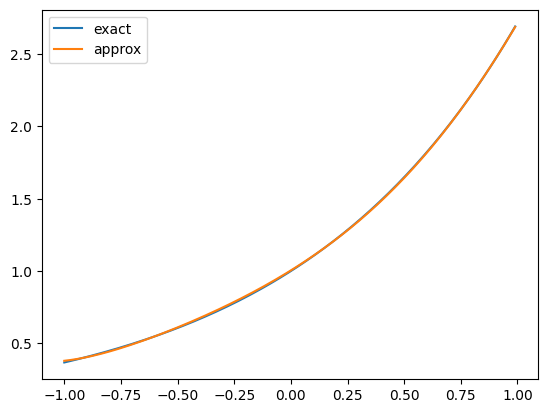

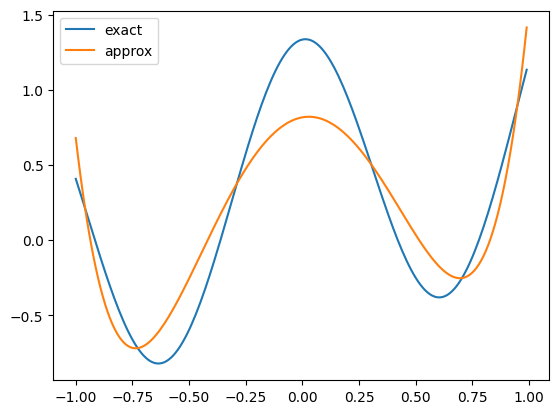

In [201]:
from random import random 
import matplotlib.pyplot as plt
import numpy as np
from math import exp, cos

def p(x,n):
    return x**n 

def f(x):
    return exp(x) 

def f1(x):
    return exp(x)/3 + cos(5*x) 

def approx_sol(a_control,x):
    return sum(a_control[j]*p(x,j) for j in range(len(a_control)))

# inefficient because we can use evaluations of f(u) and p(u,..) on all coefs at the same time
def a(n,a_control,fun,nsim=10):
    sol = 0
    for _ in range(nsim):
        u = (random()*2-1)
        sol += ((2*n+1)*(fun(u)-approx_sol(a_control,u))*p(u,n) + a_control[n])/nsim
    return sol

def plot(fun):
    a_control = [0]*8
    for j in range(len(a_control)+10):
        for n in range(len(a_control)):
            a_control[n] = a(n,a_control,fun,100)
            
    xs = np.arange(-1,1,0.01)
    ys1 = [fun(x) for x in xs]
    ys2 = [approx_sol(a_control,x) for x in xs]

    plt.plot(xs, ys1,label= "exact")
    plt.plot(xs, ys2,label= "approx")
    plt.legend()
    plt.show()
plot(f)
plot(f1)

We conjecture using something that is approximately orthonormal can help alleviate those type of problems. Approximate orthonormal basis's can be constructed by approximating the domain, weights and then using something like Gram–Schmidt (https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process). The following example will be over $[-0.5,0.5]$ using the Legendre polynomials:

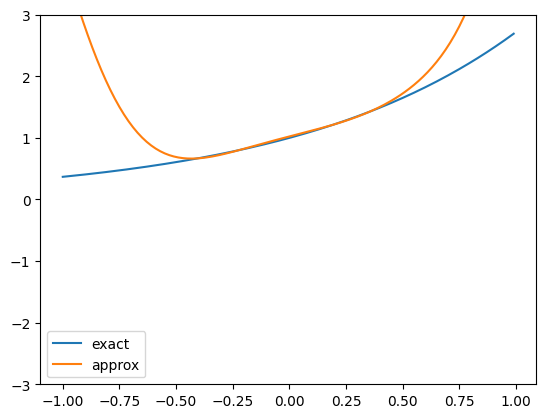

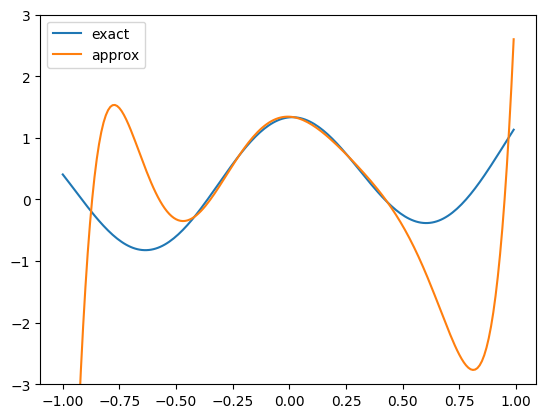

In [14]:
from random import random 
import matplotlib.pyplot as plt
import numpy as np
from math import exp, cos

# inefficient legendre polynomials RECURSION
def p(x,n):
    return ((2*n-1)*x*p(x,n-1)-(n-1)*p(x,n-2))/n if n>1 else (x if n ==1 else 1)

def f(x):
    return exp(x) 

def f1(x):
    return exp(x)/3 + cos(5*x) 

def approx_sol(a_control,x):
    return sum(a_control[j]*p(x,j) for j in range(len(a_control)))

# inefficient because we can use evaluations of f(u) and p(u,..) on all coefs at the same time
def a(n,a_control,fun,nsim=10):
    sol = 0
    for _ in range(nsim):
        u = (random()*2-1)/2
        sol += (((2*n+1)*2)*(fun(u)-approx_sol(a_control,u))*p(u,n) + a_control[n])/nsim
    return sol

def plot(fun):
    a_control = [0]*8
    for j in range(len(a_control)):
        for n in range(len(a_control)):
            a_control[n] = a(n,a_control,fun,j*10)
            
    xs = np.arange(-1,1,0.01)
    ys1 = [fun(x) for x in xs]
    ys2 = [approx_sol(a_control,x) for x in xs]

    plt.plot(xs, ys1,label= "exact")
    plt.plot(xs, ys2,label= "approx")
    plt.ylim(-3,3)
    plt.legend()
    plt.show()
plot(f)
plot(f1)

It works but we can't tell to what extend, it needs more samples ...

The following code is just exploration:

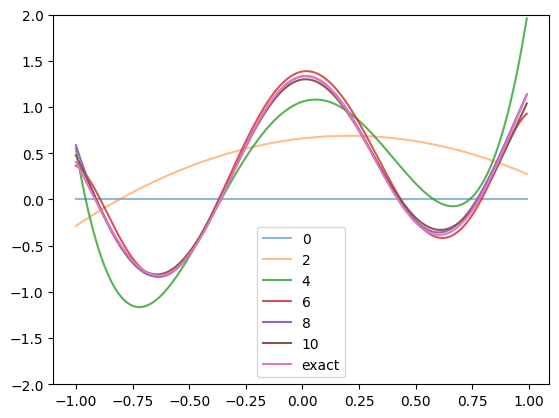

In [1]:

from random import random 
import matplotlib.pyplot as plt
import numpy as np
from math import exp, cos

# inefficient legendre polynomials RECURSION
def p(x,n):
    return ((2*n-1)*x*p(x,n-1)-(n-1)*p(x,n-2))/n if n>1 else (x if n ==1 else 1)

def f(x):
    return exp(x)/3 + cos(5*x) 

def approx_sol(a_control,x):
    return sum(a_control[j]*p(x,j) for j in range(len(a_control)))

# inefficient because we can use evaluations of f(u) and p(u,..) on all coefs at the same time
def a(n,a_control,nsim=10):
    sol = 0
    for _ in range(nsim):
        u = (random()*2-1)
        sol += ((2*n+1)*(f(u)+(random()-0.5)/5-approx_sol(a_control,u))*p(u,n) + a_control[n])/nsim
    return sol

a_control = [0]
order = 11
steps = 2
xs = np.arange(-1,1,0.01)
for j in range(order):
    for _ in range(steps):
        for n in range(len(a_control)):
            a_control[n] = a(n,a_control,5*j)

    if j%2 ==0:
        ys2 = [approx_sol(a_control,x) for x in xs]
        c = 0.5 if j/order<0.3 else(0.8 if j/order<0.6 else 1)
        plt.plot(xs, ys2,label=j, alpha = c)
    a_control.append(0)
        
ys1 = [f(x) for x in xs]

plt.plot(xs, ys1,label= "exact")
plt.legend()
plt.ylim(-2,2)
plt.show()

Ok let's try a RMC scheme with adaptive polynomial control variates (because we integrate that by hand under $5$ min):
$$
y'=y, y(0)=1
$$
Let's solve for $y$ on $[0,1]$

[1.4154726239046092, 0.3364313274133617, 0.22925484865173118, 0.16663592576008204, 0.1372741973115358, 0.11682151891254146, 0.09725498140682705, 0.08257863926679018, 0.08179188774151264, 0.05954684381739546]


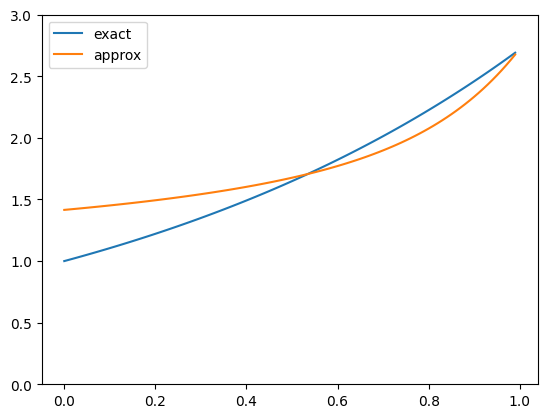

In [544]:
# still need to fix this
from random import random 
import matplotlib.pyplot as plt
import numpy as np
from math import exp, cos

def approx_sol(a_control,x):
    return sum(a_control[j]*x**j for j in range(len(a_control)))

def Iapprox_sol(a_control,t):
    return sum(a_control[j]*t**(j+1)/(j+1) for j in range(len(a_control)))
    
def Y(t,a_control):
    u = random()*t
    if t<1:
        if random()<t:
            return 1 + (Y(u,a_control)-approx_sol(a_control,u))+Iapprox_sol(a_control,t) 
        else:
            return 1+ Iapprox_sol(a_control,t)
    else:
        return 1 + t*(Y(u,a_control)-approx_sol(a_control,u))+Iapprox_sol(a_control,t)        


def a(n,a_control,nsim=10):
    sol = 0
    for _ in range(nsim):
        u = random()
        sol += ((Y(u,a_control)-approx_sol(a_control,u))*u**n + a_control[n])/nsim
    return sol

a_control = [0]*10
for j in range(3):
    for n in range(len(a_control)):
        a_control[n] = a(n,a_control,1000)
        
xs = np.arange(0,1,0.01)
ys1 = [exp(x) for x in xs]
ys2 = [approx_sol(a_control,x) for x in xs]

print(a_control)
plt.plot(xs, ys1,label= "exact")
plt.plot(xs, ys2,label= "approx")
plt.legend()
plt.ylim(0,3)
plt.show()